# Fall 2025 - Assignment 2

* Geoffroy Hébert-Emond - 11273505
* Loubna Naciri - 1

Electronic submission on ZoneCours no later than **December 5 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Option Valuation with Dynamic Volatility

The objective of this assignment is to compute a synthetic, model-based counterpart to the VIX using some of the models seen in class.

In [1]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script 

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib
from scipy.stats import gaussian_kde

from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Question 1

Using the data provided in `spx.csv`, estimate the parameters of Duan's (1995) nonaffine GARCH model (NGARCH) as described in the note. In particular, work under the assumption that innovations are $N(0,1)$. Note that the index levels provided in the csv file are ex-dividend, so that log returns computed from those will also be ex-dividend returns, that is:
$$
\log\left(\frac{S_{t+1}}{S_t}\right)
= r_f - y + \lambda \sqrt{h_{t+1}} - \frac{1}{2}h_{t+1} + \sqrt{h_{t+1}}\varepsilon_{t+1}
$$
In order to estimate the risk-premium parameter driving the cum-dividend equity premium $e^{\lambda \sqrt{h_{t+1}}}$, you should thus consider cum-dividend log-excess returns $\tilde{r}_{t+1} = \log\left(\frac{S_{t+1}}{S_t}\right) + y - r_f$. 

Here is how to approximate $y$: for dates prior to 1996-01-04, use the annual dividend yield values published by [Aswath Damodaran](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/spearn.htm?utm_source=chatgpt.com). Then, use the yields in `spx_divyields.csv` at the shortest nonzero horizon (e.g. on 2024-12-31, the yield with expiration on 2025-01-02). Remember that both sources provide annualized yields whereas the model requires a measure at the daily frequency.

Diagnose whether $\lbrace{ \varepsilon_t }\rbrace$ are indeed $N(0,1)$ by tabulating a Jarque-Bera (JB) test and an Anderson–Darling (AD) for uniformity of $\lbrace{ u_t }\rbrace = \lbrace{ \Phi(\varepsilon_t) }\rbrace$, where $\Phi$ is the CDF of the standard normal. Also discuss a qqplot of the $\lbrace{ \varepsilon_t }\rbrace$.

_______________________________
**Please note that we are using multiple points to start the optimization, in order to avoid getting stuck in a local minima. As such running question 1 can take 5+ minutes. **
____________

Estimated NGARCH(1,1) parameters (multi-start):
           lambda =  0.0414733
            omega =  1.47491e-06
            alpha =  0.0595023
             beta =  0.912369
            gamma =  0.239814
    sigma2_uncond =  5.96967e-05

Converged: True


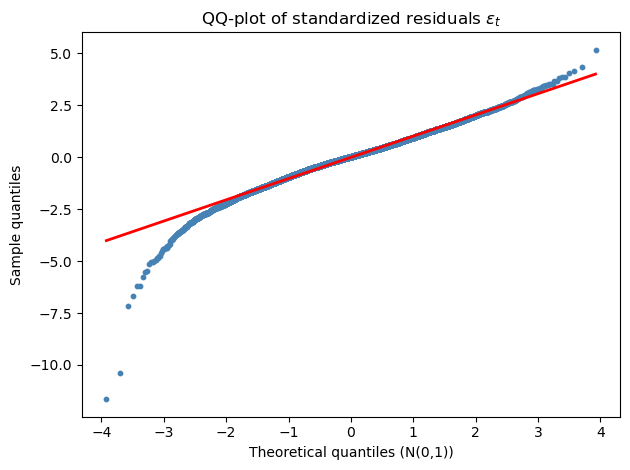

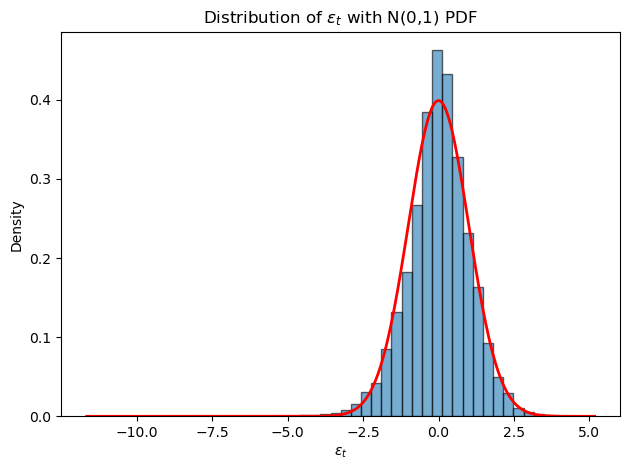

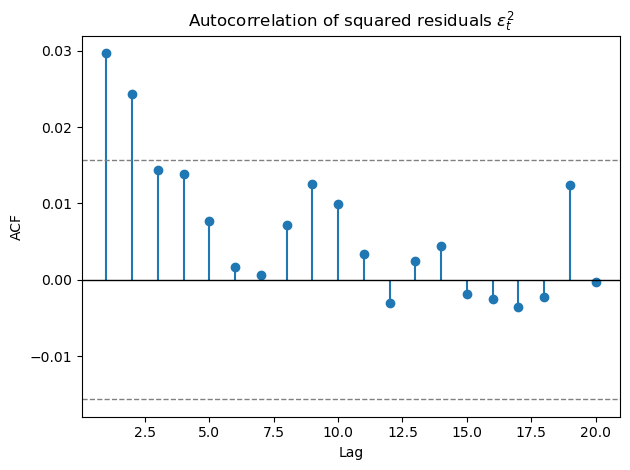

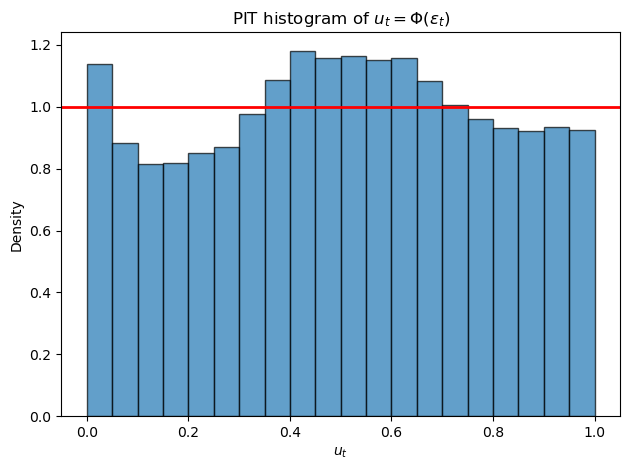


========== Residual diagnostics for epsilon t ==========

Jarque–Bera test for normality of ε_t:
  JB statistic      :  6842.9694
  p-value           :          0
  Skewness          :    -0.4827
  Pearson kurtosis  :     6.0849
  -> Reject normality of ε_t at the 5% level.

Anderson–Darling test for uniformity of u_t = Φ(ε_t):
  A^2 statistic     :    26.0556
  5% critical value :     2.4920  (large-sample)
  -> Reject uniformity of u_t at the 5% level.


In [2]:
###### Question 1 ######

from q1 import run_q1, estimate_ngarch_q1, plot_ngarch_diagnostics
spx, y_daily, rf_daily, r, h, eps, params, opt_res = run_q1()

_______________
Even after fitting a garch with the assumption N(0,1) innovations, the residuals have negative skew and high kurtosis, which suggest that they are left-skewed and heavy-tailed. As for the QQ-Plot, the NGARCH model captures the bulk of the distribution well but shows fat tails, espcially, the left tail which suggest that they are many more extreme negative residuals than a normal gaussian would predict. We can likely attribute this left tail to many crashes and market downturns in the past (Dotcom bubble, 2008 crisis, pandemic, etc..) 

The formal tests are giving us the same story The Jarque–Bera statistic is very large and the p-value is essentially zero, so we strongly reject the null hypothesis that $\varepsilon_t$ is gaussian. Furthermore, The Anderson–Darling test also rejects the null hypothesis of uniformity, which means that the transformed residuals do not behave as if they were truly standard normal across the full distribution.

Looking at the additional graphics, we can see that the histogram of $\varepsilon_t$ overlaid with the N(0,1) show more mass in the center and in the extreme left tail compared to the normal, which is in line with our other results. Then the ACF of squared residuals $\varepsilon_t^2$ is small but still shows some  autocorrelation at short lags, suggesting that the NGARCH does not capture all the volatility clustering in the data. Finally, the graph for the PIT has a hump in the middle and thinner tails which shows that the gaussian assumptions of innovations is not adequate. 
_______________


# Question 2

Download the VIX data from the [Cboe website](https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv). Between Jan 1990 and Dec 2024, plot the VIX alongside $100\times$ the annualized volatilty as filtered under the Duan model. 

Describe the similarity and differences between the two series. Don't hesitate to support your analysis with statistics and statistical tests.

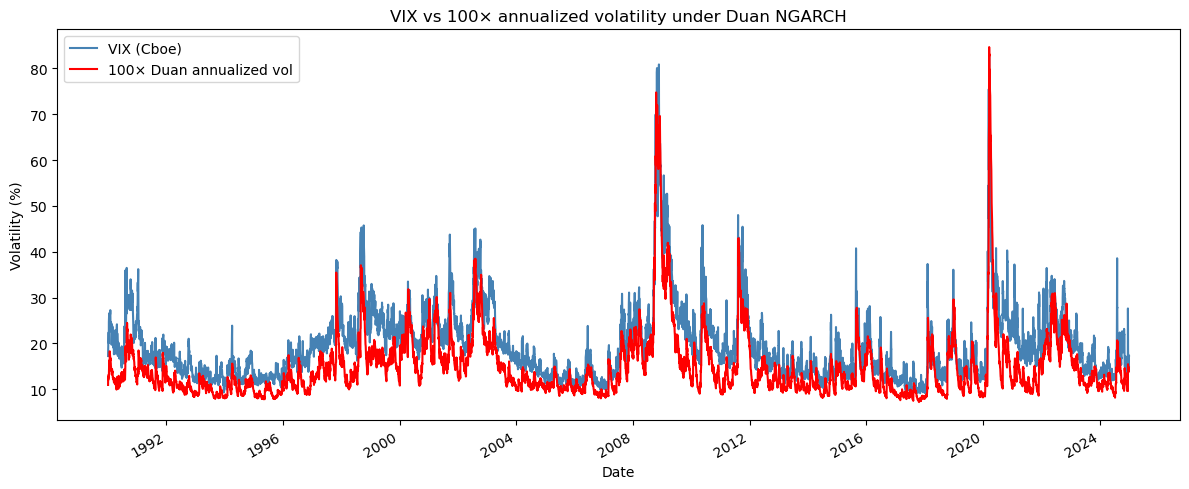

Summary statistics (Jan 1990 – Dec 2024):
               VIX  Duan_AnnVol_x100
count  8813.000000       8813.000000
mean     19.467929         14.809822
std       7.844702          7.439525
min       9.140000          7.190770
25%      13.830000         10.425471
50%      17.620000         12.686339
75%      22.820000         16.851389
max      82.690000         84.645268

Correlation matrix:
                       VIX  Duan_AnnVol_x100
VIX               1.000000          0.892769
Duan_AnnVol_x100  0.892769          1.000000


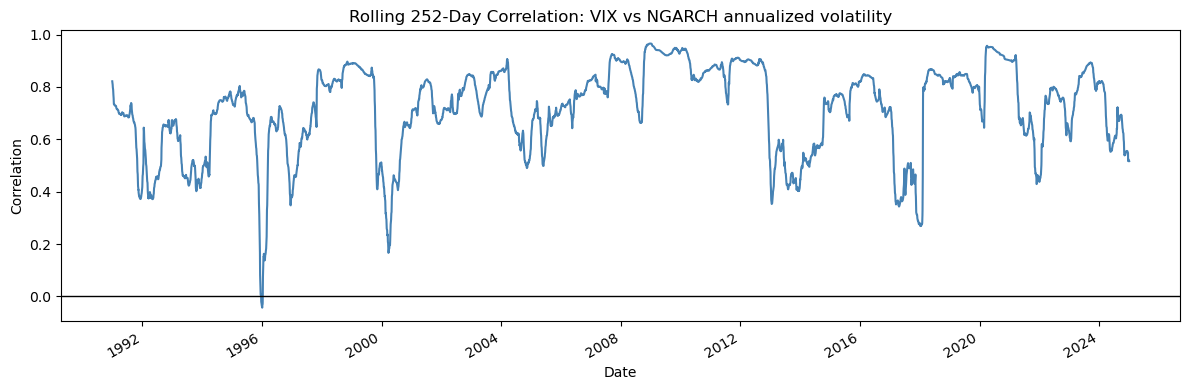

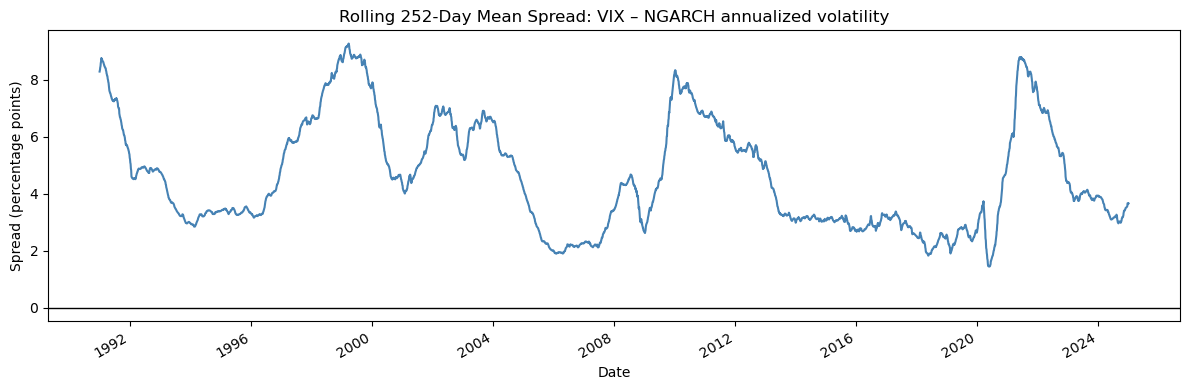


OLS regression: VIX_t = a + b * NGARCH_vol_t + error_t
--------------------------------------------------------
Number of observations: 8813
R-squared            : 0.7970

Coefficient estimates:
  alpha (intercept) :  5.5261  (SE =  0.0839,  t =  65.88)
  beta  (slope)     :  0.9414  (SE =  0.0051,  t =  186.01)

Jarque–Bera test on OLS residuals:
  JB statistic : 5294.1122
  p-value      : 0
  -> Reject normality of regression errors at 5% level.

Mean spread test: H0: E[VIX − NGARCH_vol] = 0
  Sample mean spread      : 4.6581 %-pts (465.81 bps)
  Standard error of mean  : 0.037932
  t-statistic             : 122.80
  p-value                 : 0
  -> Reject H0 at 5% level: positive mean spread,
     evidence of a statistically significant volatility risk premium.


In [3]:
####### Question 2 ######

from q2 import run_vix_duan_analysis, load_vix 
results = run_vix_duan_analysis(h, r, vix_path="VIX_History.csv")
df = results["df"]
spread_test = results["spread_test"]
ols_res = results["ols"]
vix_close = load_vix("VIX_History.csv") 

____________
Over the time frame, the NGARCH volatility under $P$ and the VIX under $Q$ move very closely together. Visually, both series will have the same spikes and the exact same time, and the correlation between both is very high. This means that the Duan NGARCH captures the main dynamics and volatility regimes of the S&P 500, as such, when the VIX jumps, the model-implied volatility under $P$ jumps as well.

However the level of volatility is quite different. The average VIX is about 19.5% versus the model which is at 14.8% so the model under $P$ is roughly 4.5 volatility points below the option-implied level on average.

We also used the 252-day rolling mean spread, which can be defined as: 

$
\text{Spread}_t = \text{VIX}_t - \text{Vol}^{\text{NGARCH}}_t 
$

The spread is is almost always positive and tends to widen sharply in crises. This shows (as expected) that the risk premium is counter cyclical and varies with time. The formal tests also confirms this. Indeed, the  mean spread is about $4.66$ percentage point and the $t$-test rejects the foloowing hypothesis: 

 $H_0 : \mathbb{E}\!\left[\text{VIX} - \text{Vol}^{\text{NGARCH}}\right] = 0$

With a  large $t$-statistic  and a $p$-value almost equal to zero. So VIX is statistically higher than NGARCH volatility, consistent with the positive risk premium in option prices.

We then decided to use the following OLS regression: 

$
\text{VIX}_t = \alpha + \beta\,\text{Vol}^{\text{NGARCH}}_t + \varepsilon_t
$

The regression gives us gives an intercept $\alpha \approx 5.5$ and slope $\beta \approx 0.94$ with $R^2 \approx 0.80$. So a one-for-one relationship in sensitivity is reasonable (since $\beta \approx 1$), but there is a positive and constant shift of about $5$–$6$ points: even when $\text{Vol}^{\text{NGARCH}}_t$ is “zero” in the regression, where the VIX would still sit around $5$–$6%$. The Jarque–Bera test on the regression residuals rejects normality, which is consistent with option-implied volatility reacting more strongly in extreme periods than a Gaussian NGARCH under $P$ can capture.

Finally, the rolling 252-day correlation is typically very high (often $0.7$–$0.9$) in “normal” times but drops during regime shifts and crises, indicating that when volatility reprices very abruptly, the risk-neutral VIX adjusts faster than the NGARCH model estimated on historical returns.

______________

# Question 3

(Ideally) On each of the 8834 days in the Jan90-Dec24 sample, evaluate the option prices of 1-month, OTM puts and calls with standardized moneyness 
$$
m = \frac{\log\frac{K}{F}}{\sqrt{(252/12) h_{t+1}}}
$$
ranging from -5 to +5. To do so, you first need to apply the LRNVR to obtain the risk-neutral parametrization of the model. Prior to 1996, you can still use Damodoran's dividend yields. From 1996, use the `spx_divyields.csv` yields interpolated at 30 calendar days. Simulate $N_S$ paths over 21-business days, with $N_S = 20,000$: For each day, draw $10,000$ shocks, use the $10,000$ antithetic variates and standardize the resulting shocks (across paths, not time) to avoid simulation noise around forward prices.

Apply the VIX methodology to these options prices and plot the "model-based" VIX alongside the model's physical volatility and the actual VIX. Discuss the similarities and differences, supporting your discussion with the necessary statistics. 

Hint: start by doing the analyzing using 1 day a week (ideally, Wednesdays), to make sure you are on the right track. That will go roughly 5 times faster than working on daily data. If your computer has multiple cores, days can be analyzed in parallel.

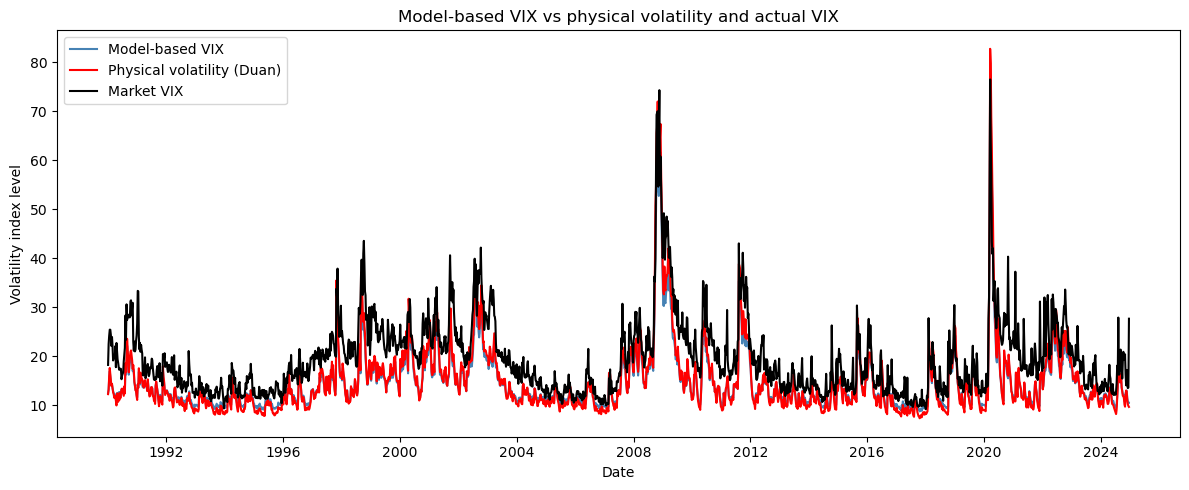

Q3 correlation matrix:
            VIX_model  Vol_phys  VIX_actual
VIX_model    1.000000  0.999406    0.893580
Vol_phys     0.999406  1.000000    0.897809
VIX_actual   0.893580  0.897809    1.000000

Q3 summary statistics:
         VIX_model     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.726375    14.828427    19.443889
std       6.430997     7.472925     7.798583
min       8.712135     7.304338     9.150000
25%      10.990370    10.383944    13.790000
50%      12.790730    12.670446    17.770000
75%      16.334906    16.899353    22.690000
max      75.534956    82.701346    76.450000


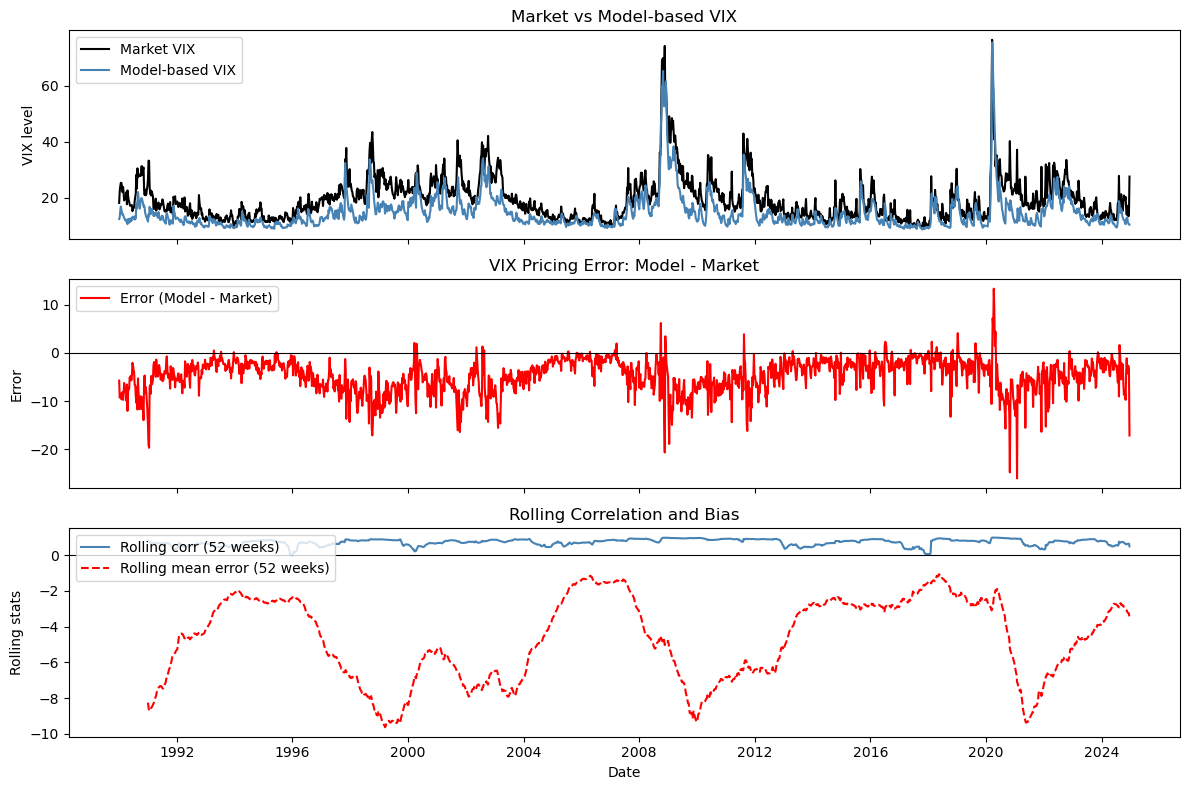

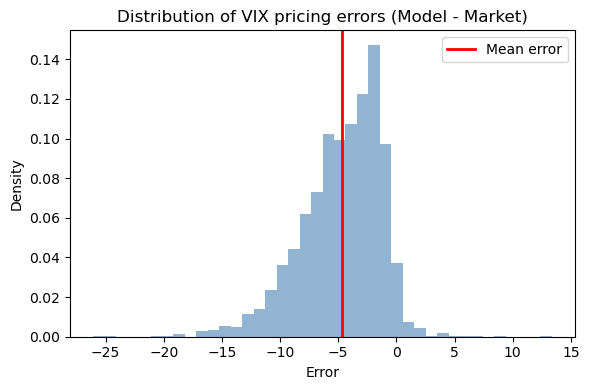

Bias (mean error): -4.717514671865264
MAE: 4.819016049304173
RMSE: 5.898538803015954


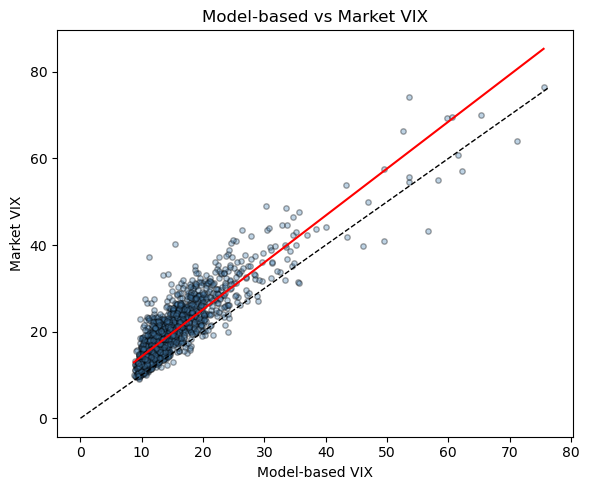

alpha (intercept): 3.4863
beta  (slope)    : 1.0836
R^2              : 0.7985


In [4]:
####### Question 3 #######

from q3 import (
    run_model_vix_analysis,
    get_rn_params,
    simulate_ngarch_paths_Q,
    build_m_grid,
    forward_and_discount,
    price_options_from_paths,
    vix_from_option_curve,
)

results_q3 = run_model_vix_analysis(
    h=h,
    r=r,
    params=params,
    spx=spx,
    rf_daily=rf_daily,
    y_daily=y_daily,
    vix_close=vix_close,
    n_paths=20000,
    horizon_days=21,
    make_plots=True,
)

_____
With the following graphics and stats, we are now able to analyze the question 3 .....
_____


# Question 4

Consider the $\lbrace{ \varepsilon_t }\rbrace$ filtered under the normality assumption. We would like to leverage their empirical distribution and the fact that quasi MLE yields consistent and asymptotically normal parameter estimates. 

Filtered historical simulation is a method in which, rather than simulating innovations from a parametric distribution, innovations are sampled from the $\lbrace{ \varepsilon_t }\rbrace$ filtered during the model's estimation. These innovation, however, have been filtered under $\mathbb{P}$ and we need to simulate under $\mathbb{Q}$. 

We can, however, apply an ad-hoc risk-neutralization using the following exponential tilt. Under $\mathbb{P}$, the probability of sampling any of the $\lbrace{ \varepsilon_t }\rbrace_{t=1}^{N_T}$ should be $1/N_T$. For a scalar tilt parameter $\eta$, define
$$
q_i(\eta)
= \frac{e^{-\eta\,\varepsilon_i}}
       {\sum_{j=1}^{N_T} e^{-\eta\,\varepsilon_j}},
\qquad i=1,\dots,{N_T}.
$$
One can demonstrate that sampling $\varepsilon^Q_i = \varepsilon_i + \lambda$ with probability $q_i(\lambda)$ yields set of innovations with null expectations. Outline how this yields an ad-hoc generalization of the LRNVR where the distribution of the $\mathbb{Q}$ shocks will have a nonnormal distribution. To illustrate this point, plot a kernel density estimate of the physical distribution of the shocks along with one on a sample of $\mathbb{Q}$ shocks. Overlay to this figure, on a secondary y-axis, the likelihood ratio between the two measures and discuss.

Empirical mean under P  (ε):    -0.005855619782808998
Empirical mean under Q (ε^Q):  -0.004299537074429363


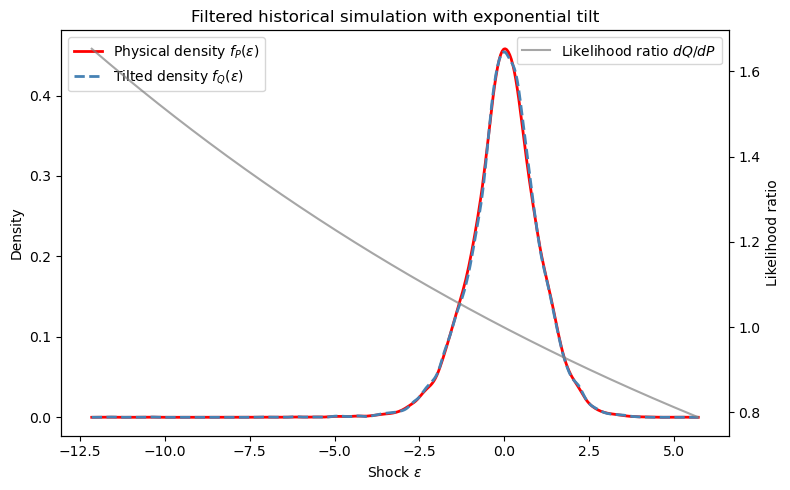

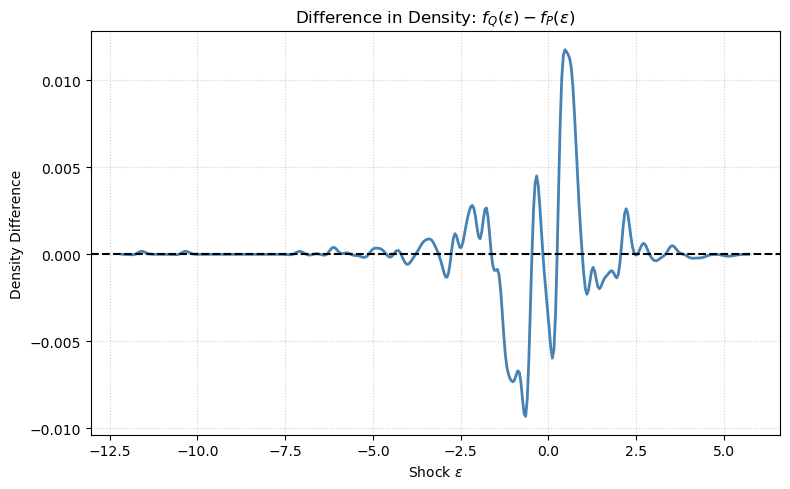

In [5]:
####### Question 4 #######

from q4 import run_exponential_tilt_analysis

results_q4 = run_exponential_tilt_analysis(
    eps=eps,
    lam=params["lambda"],
    n_samples=50_000,
    seed=123,
    make_plots=True,
)
eps_Q = results_q4["eps_Q"]
f_P   = results_q4["f_P"]
f_Q   = results_q4["f_Q"]

_____
Analyze both graphs 
_____


# Question 5

Repeat the exercise in Question 3, but using the FHS setup in Question 4 rather than $N(0,1)$ shocks. Does your VIX approximation improve? Discuss.

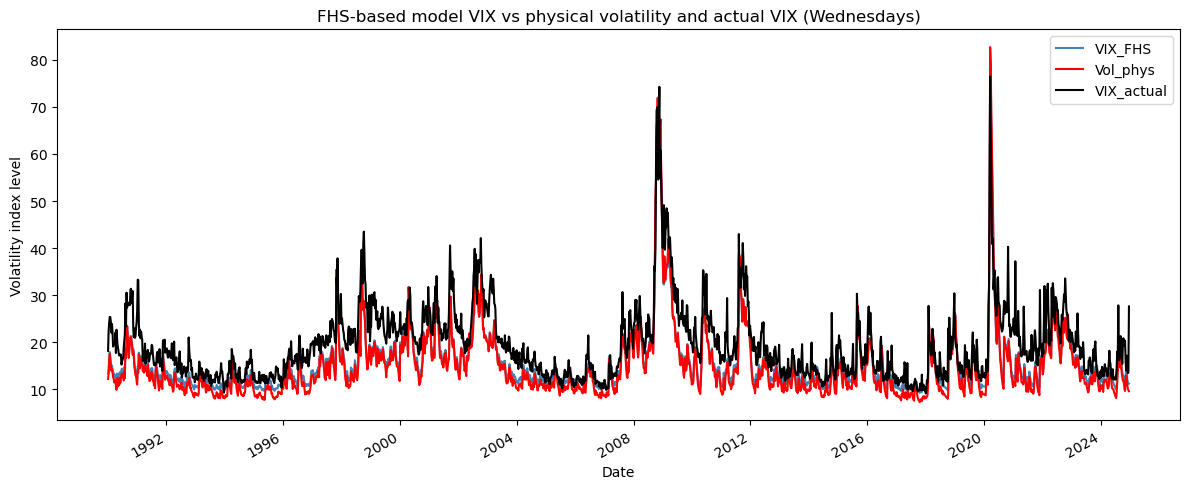

Q5 correlation matrix:
             VIX_FHS  Vol_phys  VIX_actual
VIX_FHS     1.000000  0.999474    0.893473
Vol_phys    0.999474  1.000000    0.897809
VIX_actual  0.893473  0.897809    1.000000

Q5 summary statistics:
           VIX_FHS     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     15.756636    14.828427    19.443889
std       6.888992     7.472925     7.798583
min       9.247904     7.304338     9.150000
25%      11.757319    10.383944    13.790000
50%      13.691476    12.670446    17.770000
75%      17.439130    16.899353    22.690000
max      79.434859    82.701346    76.450000


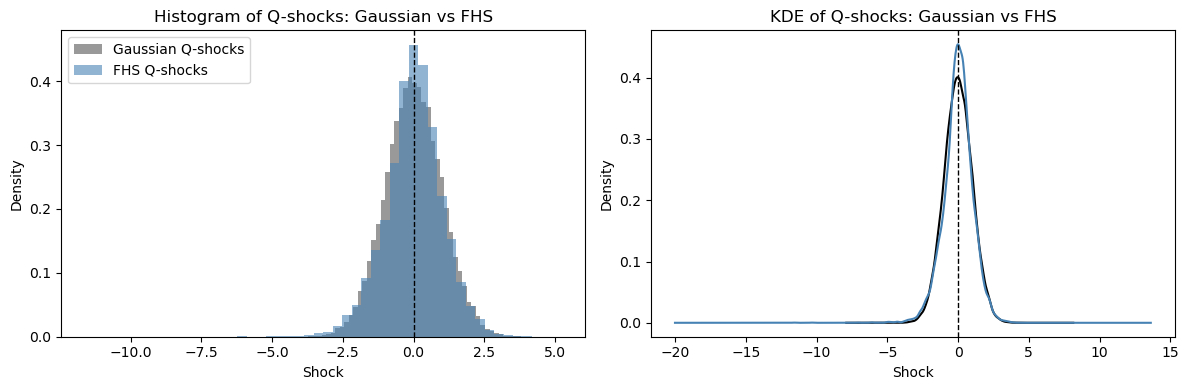


RMSE vs VIX_actual:
              RMSE
VIX_FHS   5.085532
Vol_phys  5.771738


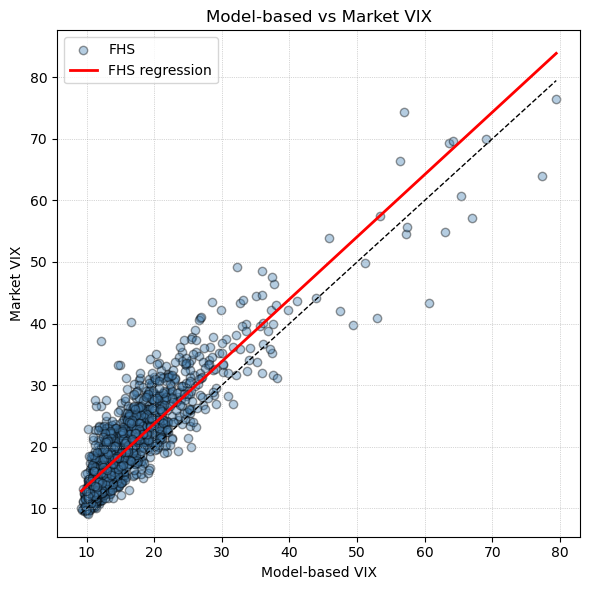

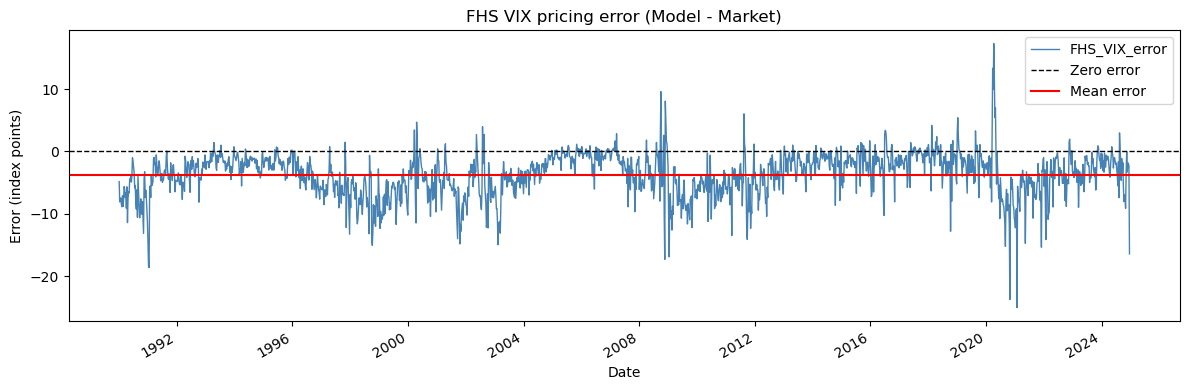


FHS pricing error summary:
count    1805.000000
mean       -3.687254
std         3.503370
min       -25.017588
25%        -5.647089
50%        -3.204324
75%        -1.235269
max        17.297599
Name: FHS_VIX_error, dtype: float64

Bias (mean error): -3.6872536187333926
MAE: 3.9546675682863217
RMSE: 5.085532164016382


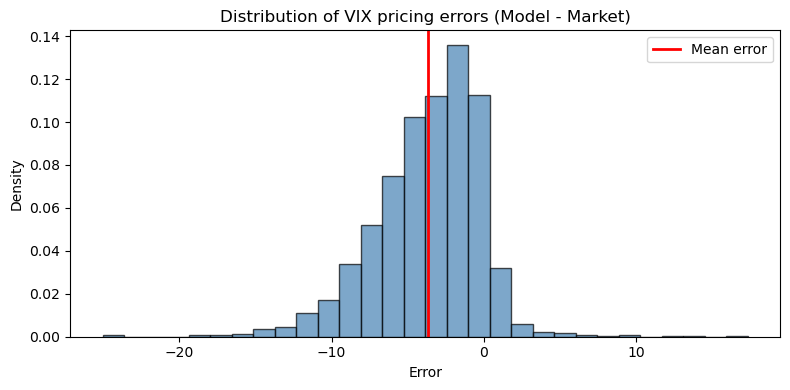

In [6]:
# Prep: series
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0 

eps_array = np.asarray(eps)     
lam = params['lambda']              


# Exponential-tilt weights and FHS sampling
def compute_Q_weights(eps_array, eta):
   
    w = np.exp(-eta * eps_array)
    q = w / w.sum()
    return q

q_weights = compute_Q_weights(eps_array, lam)


def draw_eps_Q(eps_array, q_weights, lam, n_paths, rng):
    
    N = len(eps_array)
    idx = rng.choice(N, size=n_paths, replace=True, p=q_weights)
    eps_Q = eps_array[idx] + lam
    return eps_Q


#  Risk-neutral NGARCH
def get_rn_params(params):

    params_Q = params.copy()
    params_Q['gamma']  = params['gamma'] + params['lambda']
    params_Q['lambda'] = 0.0
    return params_Q

params_Q = get_rn_params(params)


#  NGARCH path simulation under Q
def simulate_ngarch_paths_Q_FHS(S0, h0, rf_d, y_d,
                                params_Q, eps_array, q_weights, lam,
                                n_days=21, n_paths=20000, random_state=None):

    rng = np.random.default_rng(random_state)

    omega = params_Q['omega']
    alpha = params_Q['alpha']
    beta  = params_Q['beta']
    gammaQ = params_Q['gamma']

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for _ in range(n_days):
        eps_Q = draw_eps_Q(eps_array, q_weights, lam, n_paths, rng)

        r_excess = -0.5 * h + np.sqrt(h) * eps_Q

        log_ret = r_excess - y_d + rf_d
        S *= np.exp(log_ret)

        h = omega + alpha * h * (eps_Q - gammaQ) ** 2 + beta * h

    return S, h


# FHS-based model VIX 
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only 
wed_dates = common_dates[common_dates.weekday == 2]

m_grid = build_m_grid()
n_paths = 20000       
horizon_days = 21    

vix_model_fhs = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0   = spx.loc[d, 'spindx']
    h0   = h_series.loc[d]
    rf_d = rf_daily.loc[d]
    y_d  = y_daily.loc[d]

    S_T, h_T = simulate_ngarch_paths_Q_FHS(
        S0, h0, rf_d, y_d,
        params_Q, eps_array, q_weights, lam,
        n_days=horizon_days, n_paths=n_paths
    )

    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)
    strikes, C, P = price_options_from_paths(S_T, F, h0, m_grid, df)

    VIX_fhs, _ = vix_from_option_curve(strikes, C, P, F, R_f, T)
    vix_model_fhs.loc[d] = VIX_fhs


# ============================================================
# Question 5 – Graphs & Diagnostics
# ============================================================

# ---------- 0) FHS-based model VIX vs physical vol and actual VIX ----------
cols = [
    vix_model_fhs.rename("VIX_FHS"),
    duan_vol_ann.rename("Vol_phys"),
    vix_close.rename("VIX_actual"),
]
plot_df_q5 = pd.concat(cols, axis=1, join="inner").dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_df_q5.plot(ax=ax, color=["steelblue", "red", "black"])
ax.set_title("FHS-based model VIX vs physical volatility and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Q5 correlation matrix:")
print(plot_df_q5.corr())
print("\nQ5 summary statistics:")
print(plot_df_q5.describe())


# ---------- 1) Q-shocks: Histogram + KDE (Gaussian vs FHS) ----------
rng_vis = np.random.default_rng(123)
n_shocks_vis = 50_000

# FHS Q-shocks (tilted historical)
eps_Q_fhs = draw_eps_Q(eps_array, q_weights, lam, n_shocks_vis, rng_vis)

# Gaussian Q-shocks for comparison
eps_Q_gauss = rng_vis.standard_normal(n_shocks_vis)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograms
axes[0].hist(eps_Q_gauss, bins=50, density=True, alpha=0.4,
             color="black", label="Gaussian Q-shocks")
axes[0].hist(eps_Q_fhs, bins=50, density=True, alpha=0.6,
             color="steelblue", label="FHS Q-shocks")
axes[0].axvline(0.0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Histogram of Q-shocks: Gaussian vs FHS")
axes[0].set_xlabel("Shock")
axes[0].set_ylabel("Density")
axes[0].legend()

# KDEs
pd.Series(eps_Q_gauss, name="Gaussian").plot(
    kind="kde", ax=axes[1], color="black", linewidth=1.5
)
pd.Series(eps_Q_fhs, name="FHS").plot(
    kind="kde", ax=axes[1], color="steelblue", linewidth=1.5
)
axes[1].axvline(0.0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("KDE of Q-shocks: Gaussian vs FHS")
axes[1].set_xlabel("Shock")

plt.tight_layout()
plt.show()


# ---------- 2) RMSE table: Gaussian vs FHS vs Duan ----------
rmse_cols = {
    "VIX_actual": vix_close,
    "VIX_FHS": vix_model_fhs,
    "Vol_phys": duan_vol_ann,   # Duan annualized vol as baseline
}

# If you have a Gaussian NGARCH VIX series from Q3, add it:
try:
    rmse_cols["VIX_Gauss"] = vix_model_gauss  # rename if needed
except NameError:
    pass

rmse_df = pd.concat(rmse_cols.values(), axis=1, join="inner")
rmse_df.columns = list(rmse_cols.keys())

def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.mean(diff**2))

model_cols = [c for c in rmse_df.columns if c != "VIX_actual"]
rmse_vals = {name: rmse(rmse_df["VIX_actual"], rmse_df[name])
             for name in model_cols}

rmse_table = pd.DataFrame.from_dict(rmse_vals, orient="index", columns=["RMSE"])
print("\nRMSE vs VIX_actual:")
print(rmse_table)


# ---------- 3) Scatter: model VIX vs market VIX ----------
fig, ax = plt.subplots(figsize=(6, 6))

# FHS points
ax.scatter(rmse_df["VIX_FHS"], rmse_df["VIX_actual"],
           alpha=0.4, color="steelblue", edgecolors="black",
           label="FHS")

# Gaussian points if available
if "VIX_Gauss" in rmse_df.columns:
    ax.scatter(rmse_df["VIX_Gauss"], rmse_df["VIX_actual"],
               alpha=0.3, color="red", edgecolors="none",
               label="Gaussian")

# Regression line for FHS
valid = rmse_df[["VIX_FHS", "VIX_actual"]].dropna()
x_fhs = valid["VIX_FHS"].values
y_mkt = valid["VIX_actual"].values
b1, b0 = np.polyfit(x_fhs, y_mkt, 1)    # y = b0 + b1 x

x_line = np.linspace(x_fhs.min(), x_fhs.max(), 100)
ax.plot(x_line, b0 + b1 * x_line, color="red", linewidth=2,
        label="FHS regression")

# 45° line
xy_min = min(valid.min().min(), valid["VIX_actual"].min())
xy_max = max(valid.max().max(), valid["VIX_actual"].max())
ax.plot([xy_min, xy_max], [xy_min, xy_max],
        color="black", linestyle="--", linewidth=1)

ax.set_xlabel("Model-based VIX")
ax.set_ylabel("Market VIX")
ax.set_title("Model-based vs Market VIX")
ax.legend()
ax.grid(True, linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.show()


# ---------- 4) VIX pricing error with FHS (time-series) ----------
err_fhs = plot_df_q5["VIX_FHS"] - plot_df_q5["VIX_actual"]
err_fhs.name = "FHS_VIX_error"

fig, ax = plt.subplots(figsize=(12, 4))
err_fhs.plot(ax=ax, color="steelblue", linewidth=1)

ax.axhline(0.0, color="black", linestyle="--", linewidth=1,
           label="Zero error")
ax.axhline(err_fhs.mean(), color="red", linestyle="-", linewidth=1.5,
           label="Mean error")

ax.set_title("FHS VIX pricing error (Model - Market)")
ax.set_ylabel("Error (index points)")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

print("\nFHS pricing error summary:")
print(err_fhs.describe())

bias = err_fhs.mean()
mae  = err_fhs.abs().mean()
rmse_err = np.sqrt(np.mean(err_fhs**2))
print(f"\nBias (mean error): {bias}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse_err}")


# ---------- 5) Distribution of FHS pricing error (hist only) ----------
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(err_fhs, bins=30, density=True, alpha=0.7,
        color="steelblue", edgecolor="black")
ax.axvline(err_fhs.mean(), color="red", linewidth=2,
           label="Mean error")

ax.set_title("Distribution of VIX pricing errors (Model - Market)")
ax.set_xlabel("Error")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()



_____
With the following graphics and stats, we are now able to analyze the question 5 .....
_____

# Bonus question

Instead of an ad-hoc non-normal NGARCH model, repeat the above analysis with the Bates (2000) model.

_____
the model takes about an hour to run bates
___________